# Number Counts




In [1]:
import numpy as np
from astropy.table import Table, join, setdiff
from astropy.io import fits
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
from scipy.interpolate import interp1d

import scipy
from scipy.optimize import curve_fit
import scipy.stats
import pickle
import os
from pymoc.util import catalog
from pymoc import MOC
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
#import utils

from herschelhelp_internal.utils import flux_to_mag, mag_to_flux, inMoc, coords_to_hpidx
from herschelhelp.external import convert_table_for_cigale

In [2]:
def get_center(bins):
    """
    """
    return (bins[:-1] + bins[1:]) / 2

In [3]:
def moc_from_cat(ra, dec, order):
    """
    """
    # Get healpix from ra, dec [deg]
    ra = np.array(ra)
    dec = np.array(dec)  
    theta = 0.5 * np.pi - np.radians(dec)
    phi = np.radians(ra)
    healpix = hp.ang2pix(2**order, theta, phi, nest=True)
    
    # create MOC
    moc=MOC()
    moc.add(order,healpix)
    
    return moc
    
    

In [4]:
def cp_vics(F, m, m50):
    C = 1 / (1 + np.exp(F*(m - m50)))
    
    return C

In [5]:
def cp_sdss(f, m, m50, sigma):
    C = f / (1 + np.exp((m - m50) / sigma))
    
    return C

In [6]:
def plot_Ncounts_cp(cats, bands, areas, bins, labels, completeness,low,up, xlim=[15,30], mg_lim=[18,28]):
    """
    """

    fig = plt.figure(figsize=(12,7))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    fig.subplots_adjust(hspace=0, wspace=0)
    plt.xlim(xlim)

    bins_center = get_center(bins)

    hists = {}
    for i, cat in enumerate(cats):
        mask = (~np.isnan(cat[bands[i]])) & (np.isfinite(cat[bands[i]]))
        hist = np.histogram(cat[bands[i]][mask], bins = bins)
        binwidth = bins_center[2] - bins_center[1]
        hists['hist'+str(i)] = hist[0]/(binwidth*areas[i])
        ax1.plot(bins_center, np.log10(hists['hist'+str(i)]), label=labels[i])

        ax1.set_xlabel('magnitude')
        ax1.set_ylabel('log (N [deg.$^{-2}$ dex$^{-1}$])')
        ax1.legend()

    hists = Table(hists)
    
    if len(cats) > 1:
        y = hists['hist1']/hists['hist0']

        if mg_lim is not None:

            ax2.plot(bins_center, y)
            ax2.plot(bins_center, len(bins_center) *[completeness], color='green')
            ax2.axhline(completeness)
            ax2.set_ylabel('C')
            ax2.axis(ymin=0.0,ymax=1.)

            # Vertical lines
            f = interp1d(bins_center, y)
            xnew = np.linspace(mg_lim[0], mg_lim[1], num=50, endpoint=True)
            ynew = f(xnew)
#             ind = np.where((ynew >= low) & (ynew <= up))[0]  

            ind = min(enumerate(ynew), key=lambda x: abs(x[1]-completeness))[0]
            mag_cut = xnew[ind]
            print('Magnitud cut: ', mag_cut)

            ax2.axvline(mag_cut,0,1,color='orange')


#             if len(ind) == 0:
#                 print('len ind == 0')
#                 print('ynew: ', ynew)
#                 print('xnew: ', xnew)
#                 mag_cut = [0]
#             else:
#                 mag_cut = xnew[ind[-1]]
#                 print('Magnitud cut: ', mag_cut)
#                 ax2.axvline(mag_cut,0,1,color='orange')
#                 for l in ind:
#                     ax2.vlines(xnew[l],0,1)

            return hists, mag_cut

    return hists


In [7]:
# cats = [deeper_survey, hs82_]
# bands_all = [bands_deep[i], bands[i]]
# areas_all = [area_deeper, area_hs82]

# hists = {}
# for i, cat in enumerate(cats):
#     mask = (~np.isnan(cat[bands_all[i]])) & (np.isfinite(cat[bands_all[i]]))
#     hist = np.histogram(cat[bands_all[i]][mask], bins = bins)
#     binwidth = bins_center[2] - bins_center[1]
#     hists['hist'+str(i)] = hist[0]/(binwidth*areas_all[i])


# hists = Table(hists)
# y = hists['hist1']/hists['hist0']

# plt.plot(bins_center,y)
# plt.plot(xnew,ynew)
# vlines = np.where((ynew>0.88) & (ynew < 0.92))[0]
# plt.hlines(0.9,16,28)
# for l in vlines:
#     plt.vlines(xnew[l],0,1)
    
# plt.ylim(0,1)


### Catalogues from HS-82 and deeper surveys

In [8]:
DMU_DIR = '../dmu_products/'
FIELD = 'Herschel-Stripe-82'
# final_cat = 'master_catalogue_herschel-stripe-82_20180307.fits'
# depths_cat = Table.read('../dmu_products/dmu1/dmu1_ml_Herschel-Stripe-82/data/depths_herschel-stripe-82_20180307.fits', memmap=True)

In [9]:
# Different surveys to compare

### INDIVIDUAL ###

######### OPTICAL ##############
################################

# DES (ELAIS-S1 & XMM-LSS Similar depth)
#######################################################################
des_hs82 = DMU_DIR + 'dmu1/dmu1_ml_Herschel-Stripe-82/data_tmp/DES.fits'
des_hs82_moc = DMU_DIR + 'dmu0/dmu0_DES/data/DES-DR1_Herschel-Stripe-82_MOC.fits'
#######################################################################
#xmm-lss
des_xmmlss = DMU_DIR + 'dmu1/dmu1_ml_XMM-LSS/data_tmp/DES.fits'
des_xmmlss_moc = DMU_DIR + 'dmu0/dmu0_DES/data/DES-DR1_XMM-LSS_MOC.fits'

# DECaLS
#######################################################################
decals_hs82 = DMU_DIR + 'dmu1/dmu1_ml_Herschel-Stripe-82/data_tmp/DECaLS.fits'
decals_hs82_moc = DMU_DIR + 'dmu0/dmu0_DECaLS/data/DECaLS_Herschel-Stripe-82_MOC.fits'
#######################################################################
# decals_xmmlss = DMU_DIR + 'dmu1/dmu1_ml_XMM-LSS/data_tmp/DECaLS.fits'
# decals_xmmlss_moc = DMU_DIR + 'dmu0/dmu0_DECaLS/data/DECaLS_XMM-LSS_MOC.fits'

decals_cosmos = DMU_DIR + '../dmu_products/dmu1/dmu1_ml_COSMOS/data_tmp/DECaLS.fits'
decals_cosmos_moc = DMU_DIR + '../dmu_products/dmu0/dmu0_DECaLS/data/DECaLS_COSMOS_MOC.fits'



### Load in catalogues  and MOCs


In [10]:
# Files used
###############################
all_hs82 = [des_hs82, decals_hs82]
all_hs82_moc = [des_hs82_moc, decals_hs82_moc]

all_deeper = [des_xmmlss, decals_cosmos]
all_deeper_moc = [des_xmmlss_moc, decals_cosmos_moc]



i = 1
##############
cat_hs82 = all_hs82[i] #vics_hs82_dmu0 
mocfile = all_hs82_moc[i] #vics_hs82_dmu0_moc 

cat_deeper = all_deeper[i]
mocfile_deeper = all_deeper_moc[i]


# Read survey and MOCs
###############################
hs82_ = Table.read(cat_hs82, memmap=True)
deeper_survey = Table.read(cat_deeper)#, memmap=True)

moc_hs82 = MOC()
moc_hs82.read(mocfile)
    
moc_deeper = MOC()
moc_deeper.read(mocfile_deeper)

# # Areas
area_hs82 = moc_hs82.area_sq_deg
area_deeper = moc_deeper.area_sq_deg


In [11]:
xcol = 'mag'

if xcol == 'mag':
    sw = 'm_'
    bins = np.linspace(15,30,100) 
    
if xcol == 'flux':
    sw = 'f_'
    bins = np.arange(15,50,0.1)
    

bins_center = get_center(bins)

bands = []
bands_err = []
for col in hs82_.colnames:
    if col.startswith(sw) and not col.startswith(sw+'ap'):
#     if col.startswith(sw+'ap'):
        bands.append(col)
        bands_err.append(sw[0]+'err_'+col[2:])
        
# bands = ['MAG_AUTO', 'JMAG_AUTO']

print('bands: ' , bands)
# print('bands_err: ' , bands_err)

bands_deep = []
for col in deeper_survey.colnames:
    if col.startswith(sw) and not col.startswith(sw+'ap'):
#     if col.startswith(sw+'ap'):
        bands_deep.append(col)

print('bands_deep: ' , bands_deep)


bands:  ['m_decam_g', 'm_decam_r', 'm_decam_z']
bands_deep:  ['m_decam_g', 'm_decam_r', 'm_decam_z']


In [13]:
# bands = [bands[1], bands[2], bands[-1]]
# bands_deep = [bands_deep[2], bands_deep[-1]] #bands_deep[1:]

In [12]:
bands, bands_deep

(['m_decam_g', 'm_decam_r', 'm_decam_z'],
 ['m_decam_g', 'm_decam_r', 'm_decam_z'])

In [13]:
hs82_['sn_g'] = hs82_['f_decam_g'] / hs82_['ferr_decam_g']
hs82_['sn_r'] = hs82_['f_decam_r'] / hs82_['ferr_decam_r']
# hs82_['sn_i'] = hs82_['f_decam_i'] / hs82_['ferr_decam_i']
hs82_['sn_z'] = hs82_['f_decam_z'] / hs82_['ferr_decam_z']
# hs82_['sn_y'] = hs82_['f_decam_y'] / hs82_['ferr_decam_y']

In [14]:
# Completeness curves from DES (ref.: 2018arXiv180103181A) - sources with S/N > 5
g_band = Table.read('./data/completeness_curves/des/g_band.csv')
r_band = Table.read('./data/completeness_curves/des/r_band.csv')
i_band = Table.read('./data/completeness_curves/des/i_band.csv')
z_band = Table.read('./data/completeness_curves/des/z_band.csv')


Magnitud cut:  24.53061224489796
Magnitud cut:  24.73469387755102
Magnitud cut:  25.95918367346939
Magnitud cut:  23.918367346938776
Magnitud cut:  27.387755102040817


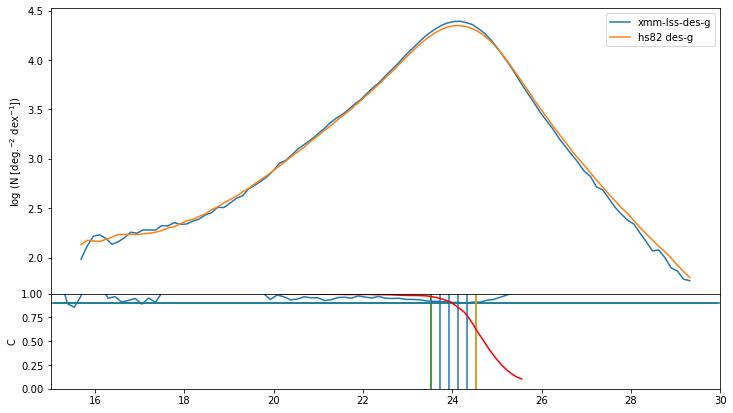

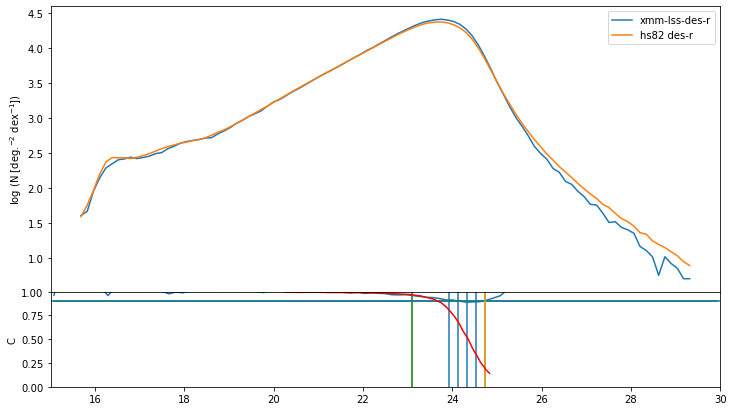

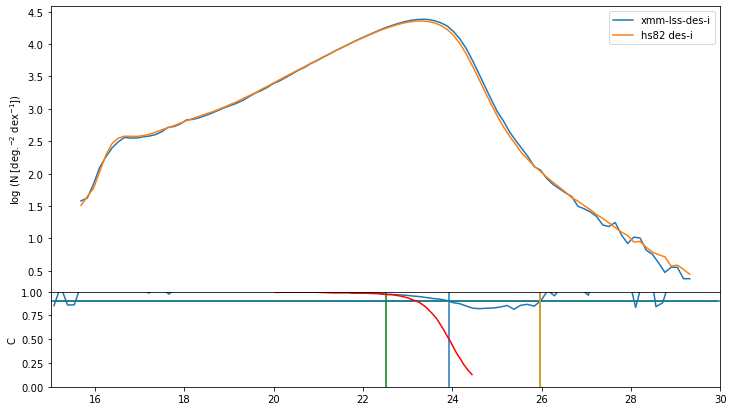

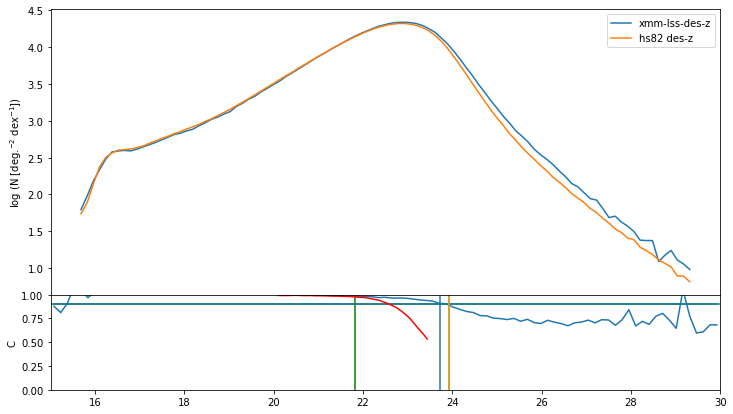

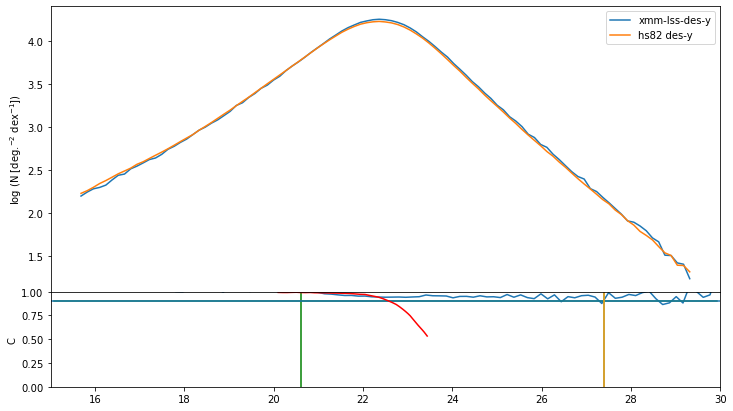

In [33]:
filters = ['g', 'r', 'i','z', 'y']
cp = 0.9
f_des_10sg = [23.52, 23.10, 22.51, 21.81, 20.61]

index = [ind_g, ind_r, ind_i, ind_z,ind_y]
cp_curves = [g_band, r_band, i_band, z_band, z_band] # I don't have the Y band

for i, f in enumerate(filters):
    ind = index[i]
    hists, magcut = plot_Ncounts_cp([deeper_survey, hs82_],[bands_deep[i], bands[i]],[area_deeper, area_hs82], bins, ['xmm-lss-des-{}'.format(f), 'hs82 des-{}'.format(f)],cp, 0.88,0.92);#, xlim=xlim, mg_lim=mg_lim);
    plt.vlines(f_des_10sg[i],0,1, color='green')
    plt.plot(cp_curves[i]['x'], cp_curves[i]['y'], color='red')
    
    plt.savefig('./data/figs/NCounts/nc_xmm-lss_hs82_des-{}.png'.format(f))

In [17]:
ind_g = hs82_['sn_g'] > 5
ind_r = hs82_['sn_r'] > 5
ind_i = hs82_['sn_i'] > 5
ind_z = hs82_['sn_z'] > 5
ind_y = hs82_['sn_y'] > 5

<ipython-input-7-a1698c526b25>:20: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(bins_center, np.log10(hists['hist'+str(i)]), label=labels[i])


Magnitud cut:  23.306122448979593


<ipython-input-7-a1698c526b25>:20: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(bins_center, np.log10(hists['hist'+str(i)]), label=labels[i])


Magnitud cut:  23.10204081632653


<ipython-input-7-a1698c526b25>:20: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(bins_center, np.log10(hists['hist'+str(i)]), label=labels[i])


Magnitud cut:  22.693877551020407


<ipython-input-7-a1698c526b25>:20: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(bins_center, np.log10(hists['hist'+str(i)]), label=labels[i])


Magnitud cut:  21.877551020408163


<ipython-input-7-a1698c526b25>:20: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(bins_center, np.log10(hists['hist'+str(i)]), label=labels[i])


Magnitud cut:  20.653061224489797


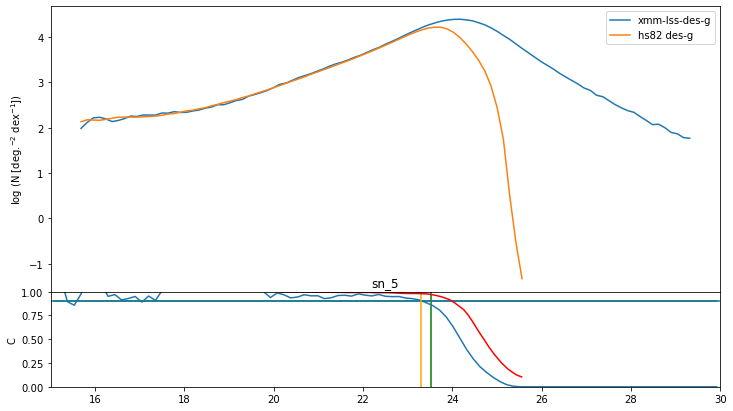

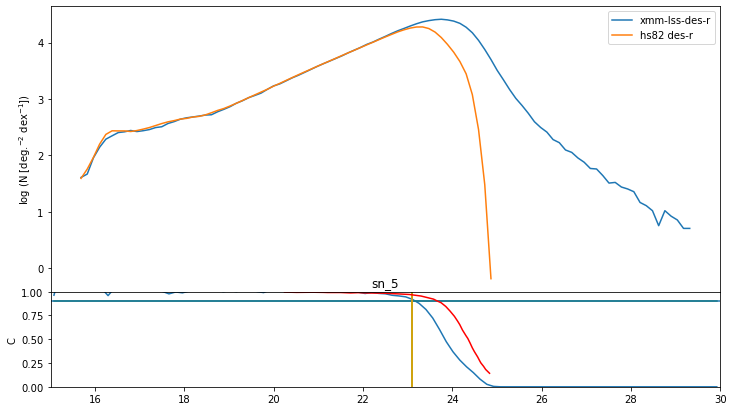

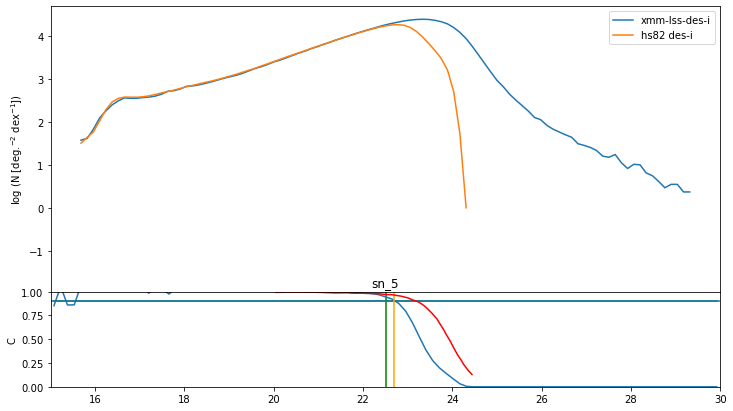

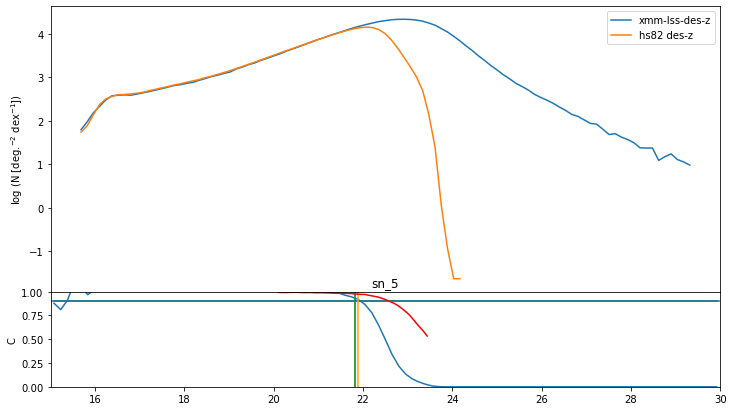

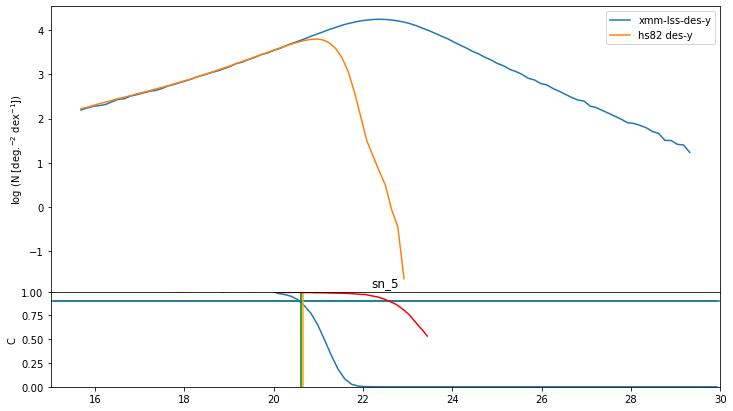

In [18]:
filters = ['g', 'r', 'i','z', 'y']
cp = 0.9
f_des_10sg = [23.52, 23.10, 22.51, 21.81, 20.61]
magcuts_des = {}

index = [ind_g, ind_r, ind_i, ind_z, ind_y]
cp_curves = [g_band, r_band, i_band, z_band, z_band] # I don't have the Y band

for i, f in enumerate(filters):
    ind = index[i]
    hists, magcut = plot_Ncounts_cp([deeper_survey, hs82_[ind]],[bands_deep[i], bands[i]],[area_deeper, area_hs82], bins, ['xmm-lss-des-{}'.format(f), 'hs82 des-{}'.format(f)],cp, 0.88,0.92);#, xlim=xlim, mg_lim=mg_lim);
    magcuts_des[f] = magcut
    plt.vlines(f_des_10sg[i],0,1, color='green')
    plt.plot(cp_curves[i]['x'], cp_curves[i]['y'], color='red')
    plt.title('sn_5')
        
#     plt.savefig('./data/figs/NCounts/nc_xmm-lss_hs82_sn10_des-{}.png'.format(f))

In [19]:
magcuts_des

{'g': 23.306122448979593,
 'r': 23.10204081632653,
 'i': 22.693877551020407,
 'z': 21.877551020408163,
 'y': 20.653061224489797}

Magnitud cut:  21.26530612244898
Magnitud cut:  25.551020408163264
Magnitud cut:  19.632653061224488


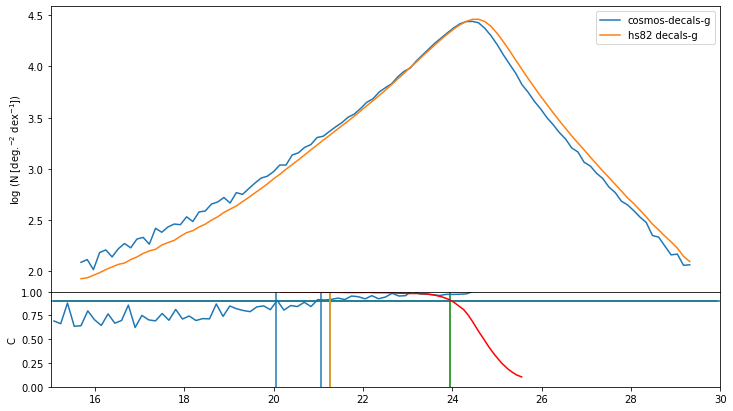

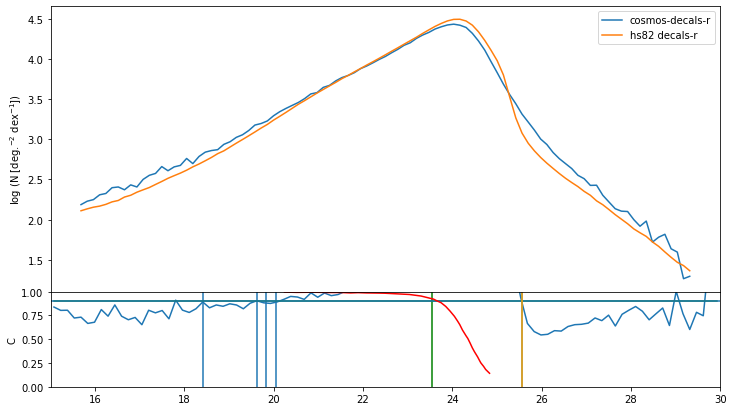

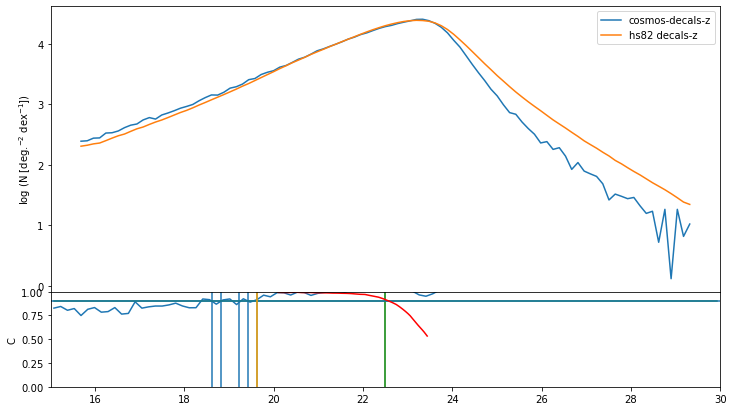

In [44]:
filters = ['g', 'r', 'z']
cp = 0.9
f_decals_5sg = [23.95, 23.54, 22.50]
magcuts = {}

index = [ind_g, ind_r, ind_z]
cp_curves = [g_band, r_band, z_band] # from DES

for i, f in enumerate(filters):
    ind = index[i]
    hists, magcut = plot_Ncounts_cp([deeper_survey, hs82_],[bands_deep[i], bands[i]],[area_deeper, area_hs82], bins, ['cosmos-decals-{}'.format(f), 'hs82 decals-{}'.format(f)],cp, 0.88,0.92);#, xlim=xlim, mg_lim=mg_lim);
    plt.vlines(f_decals_5sg[i],0,1, color='green')
    plt.plot(cp_curves[i]['x'], cp_curves[i]['y'], color='red')
    
#     plt.savefig('./data/figs/NCounts/nc_hs82-cosmos-decals-{}.png'.format(f))

In [15]:
ind_g = hs82_['sn_g'] > 5
ind_r = hs82_['sn_r'] > 5
ind_z = hs82_['sn_z'] > 5

<ipython-input-6-a1698c526b25>:20: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(bins_center, np.log10(hists['hist'+str(i)]), label=labels[i])


Magnitud cut:  21.06122448979592


<ipython-input-6-a1698c526b25>:20: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(bins_center, np.log10(hists['hist'+str(i)]), label=labels[i])


Magnitud cut:  19.632653061224488


<ipython-input-6-a1698c526b25>:20: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(bins_center, np.log10(hists['hist'+str(i)]), label=labels[i])


Magnitud cut:  19.632653061224488


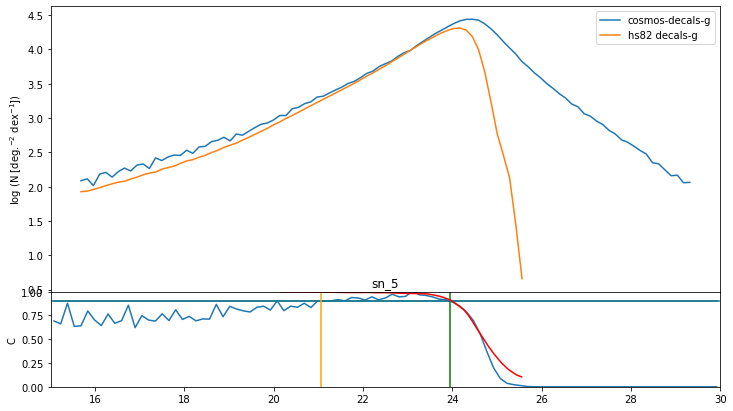

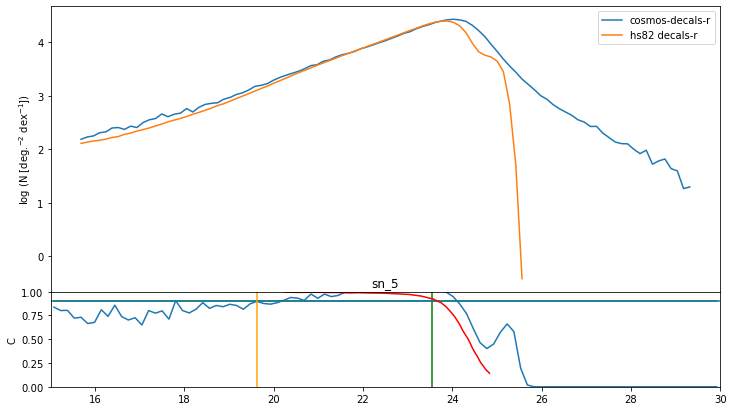

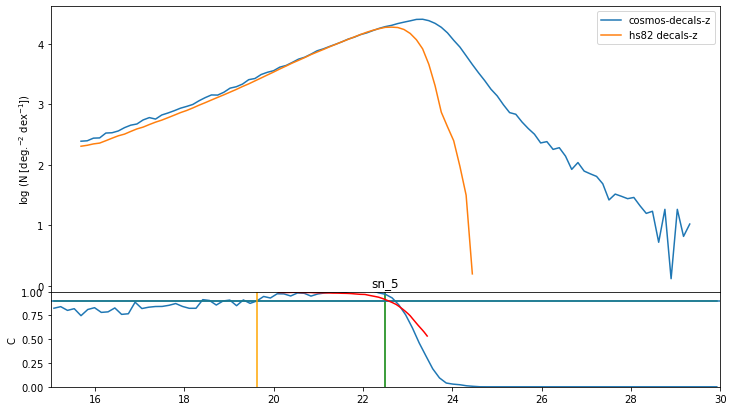

In [16]:
filters = ['g', 'r', 'z']
cp = 0.9
f_decals_5sg = [23.95, 23.54, 22.50]
magcuts_decals = {}

index = [ind_g, ind_r, ind_z]
cp_curves = [g_band, r_band, z_band] # from DES

decals_mg = {}
for i, f in enumerate(filters):
    ind = index[i]
    hists, magcut = plot_Ncounts_cp([deeper_survey, hs82_[ind]],[bands_deep[i], bands[i]],[area_deeper, area_hs82], bins, ['cosmos-decals-{}'.format(f), 'hs82 decals-{}'.format(f)],cp, 0.88,0.92);#, xlim=xlim, mg_lim=mg_lim);
    magcuts_decals[f] = magcut    

    plt.vlines(f_decals_5sg[i],0,1, color='green')
    plt.plot(cp_curves[i]['x'], cp_curves[i]['y'], color='red')
    plt.title('sn_5')
#     plt.savefig('./data/figs/NCounts/nc_hs82-cosmos_sn3_decals-{}.png'.format(f))

In [17]:
magcuts_decals

{'g': 21.06122448979592, 'r': 19.632653061224488, 'z': 19.632653061224488}

In [21]:
magcuts_des = {'g': 23.306122448979593,
 'r': 23.10204081632653,
 'i': 22.693877551020407,
 'z': 21.877551020408163,
 'y': 20.653061224489797}

magcuts_des

{'g': 23.306122448979593,
 'r': 23.10204081632653,
 'i': 22.693877551020407,
 'z': 21.877551020408163,
 'y': 20.653061224489797}

In [19]:
f_decals_5sg = {'g':23.95, 'r':23.54, 'z':22.5}
f_decals_5sg

{'g': 23.95, 'r': 23.54, 'z': 22.5}

In [ ]:
f_des_10sg = [23.52, 23.10, 22.51, 21.81, 20.61]
